In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

In [2]:
import warnings 

In [3]:
warnings.filterwarnings("ignore")

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll

In [5]:
import sys 
sys.path.append('../')

In [6]:
from fmds.models.diffusion.diffusionـsde import DiffusionSDE

In [7]:
from fmds.utils.io.read import RawDataReader

In [8]:
import  fmds.config as cfg 
from fmds.settings import Settings

In [9]:
rdr = RawDataReader(raw_data_directory=Settings.backfill.paths.RAW_DATA_PATH)

In [10]:
equity_data = rdr.read_30_equities()

In [11]:
# n_samples = 1000

In [12]:
# data , _ = make_swiss_roll(n_samples, noise=0.5)

In [13]:
# data=data[:,[0,2]]

In [14]:
# data.shape

In [15]:
equity_data

,Unnamed: 0,index,tradeDate,ClosePrice,Ticker
0,0,0,NaN,132.21,LLY
1,1,1,2020-01-03 00:00:00,131.77,LLY
2,2,2,2020-01-06 00:00:00,132.26,LLY
3,3,3,2020-01-07 00:00:00,132.51,LLY
4,4,4,2020-01-08 00:00:00,133.71,LLY
...,...,...,...,...,...
42167,42167,1362,2025-06-04 00:00:00,71.37,KO
42168,42168,1363,2025-06-05 00:00:00,70.91,KO
42169,42169,1364,2025-06-06 00:00:00,71.35,KO
42170,42170,1365,2025-06-09 00:00:00,71.77,KO


In [16]:
equity_data.columns.tolist()

['Unnamed: 0', 'index', 'tradeDate', 'ClosePrice', 'Ticker']

In [17]:
equity_data=equity_data[['tradeDate', 'ClosePrice', 'Ticker']].dropna().reset_index(drop=True)

In [18]:
equity_data

,tradeDate,ClosePrice,Ticker
0,2020-01-03 00:00:00,131.77,LLY
1,2020-01-06 00:00:00,132.26,LLY
2,2020-01-07 00:00:00,132.51,LLY
3,2020-01-08 00:00:00,133.71,LLY
4,2020-01-09 00:00:00,135.92,LLY
...,...,...,...
42055,2025-06-04 00:00:00,71.37,KO
42056,2025-06-05 00:00:00,70.91,KO
42057,2025-06-06 00:00:00,71.35,KO
42058,2025-06-09 00:00:00,71.77,KO


In [19]:
equity_data['Ticker'].nunique()

32

In [20]:
equity_data['Ticker'].unique()

array(['LLY', 'MCD', 'MMM', 'MRK', 'MSFT', 'NVDA', 'PFE', 'PG', 'TRV',
       'TSLA', 'UNH', 'V', 'VZ', 'WMT', 'XOM', 'AAPL', 'AXP', 'BA', 'CAT',
       'COST', 'CSCO', 'CVX', 'DO', 'DIS', 'GE', 'GS', 'HD', 'IBM',
       'INTC', 'JNJ', 'JMP', 'KO'], dtype=object)

In [21]:
equity_data['tradeDate'] = pd.to_datetime(equity_data['tradeDate'], errors='coerce').dt.date
equity_data['ClosePrice'] = pd.to_numeric(equity_data['ClosePrice'], errors='coerce')


In [22]:
equity_data.dropna(inplace = True) 

In [23]:
equity_data

,tradeDate,ClosePrice,Ticker
0,2020-01-03,131.77,LLY
1,2020-01-06,132.26,LLY
2,2020-01-07,132.51,LLY
3,2020-01-08,133.71,LLY
4,2020-01-09,135.92,LLY
...,...,...,...
42055,2025-06-04,71.37,KO
42056,2025-06-05,70.91,KO
42057,2025-06-06,71.35,KO
42058,2025-06-09,71.77,KO


In [24]:
equity_data.sort_values(by ='tradeDate', ascending = True, inplace = True)

In [25]:
equity_data['prior_1D_return'] = equity_data['ClosePrice']/ equity_data.groupby('Ticker')['ClosePrice'].shift(1)-1

In [26]:
equity_data

,tradeDate,ClosePrice,Ticker,prior_1D_return
0,2020-01-03,131.7700,LLY,NaN
17759,2020-01-03,39.2967,WMT,NaN
4098,2020-01-03,87.0092,MRK,NaN
6830,2020-01-03,5.9018,NVDA,NaN
33394,2020-01-03,231.5800,GS,NaN
...,...,...,...,...
28686,2025-06-10,65.1500,CSCO,-0.011381
9562,2025-06-10,24.3000,PFE,0.013767
27320,2025-06-10,1007.2700,COST,0.001083
10928,2025-06-10,162.8400,PG,0.001722


In [27]:
equity_data[equity_data['Ticker'] == 'DO'].sort_values(by = 'tradeDate', ascending = True)

,tradeDate,ClosePrice,Ticker,prior_1D_return
30053,2022-03-31,7.13,DO,NaN
30054,2022-04-01,6.89,DO,-0.033661
30055,2022-04-04,7.00,DO,0.015965
30056,2022-04-05,6.78,DO,-0.031429
30057,2022-04-06,6.75,DO,-0.004425
...,...,...,...,...
30657,2024-08-27,14.34,DO,-0.007612
30658,2024-08-28,14.21,DO,-0.009066
30659,2024-08-29,14.29,DO,0.005630
30660,2024-08-30,14.34,DO,0.003499


In [28]:
equity_data['tradeDate'] = pd.to_datetime(equity_data['tradeDate'] ).dt.date

In [29]:
equity_data['tradeDate'].dtype

dtype('O')

In [30]:
# equity_data['tradeDate'] = pd.to_datetime(equity_data['tradeDate'] ) 


In [31]:
data = equity_data.pivot_table(index= 'tradeDate', 
                               columns = 'Ticker',
                               values = 'prior_1D_return').dropna(axis=1, 
                                                 how='all').dropna(axis=0,
                                                                   how='all').fillna(0)

In [32]:
data

Ticker,AAPL,AXP,BA,CAT,COST,CSCO,CVX,DIS,DO,GE,...,NVDA,PFE,PG,TRV,TSLA,UNH,V,VZ,WMT,XOM
tradeDate,,,,,,,,,,,,,,,,,,,,,
2020-01-06,0.007968,-0.004334,0.002945,-0.000674,0.000274,0.003569,-0.003388,-0.005802,0.0,0.014202,...,0.004185,-0.001284,0.001387,0.001095,0.019256,0.006942,-0.002162,-0.002152,-0.002036,0.007678
2020-01-07,-0.004703,-0.005239,0.010607,-0.013213,-0.001576,-0.006485,-0.012769,0.000343,0.0,-0.007414,...,0.012115,-0.003345,-0.006191,-0.014653,0.038801,-0.006037,-0.002643,-0.011117,-0.009266,-0.008184
2020-01-08,0.016086,0.017260,-0.017523,0.008881,0.011464,0.000632,-0.011423,-0.002059,0.0,-0.009129,...,0.001867,0.008001,0.004263,0.010728,0.049203,0.021084,0.017118,0.001846,-0.003431,-0.015080
2020-01-09,0.021241,0.018082,0.014998,-0.002505,0.016051,-0.004209,-0.001614,-0.003920,0.0,-0.002513,...,0.010983,-0.004354,0.010938,0.007393,-0.021945,-0.005678,0.006930,-0.014403,0.010331,0.007656
2020-01-10,0.002261,-0.004147,-0.019088,-0.008010,-0.007281,-0.004015,-0.009106,-0.001450,0.0,-0.020151,...,0.005349,0.015429,0.000969,-0.015332,-0.006625,0.003093,0.002691,0.002379,-0.008351,-0.008888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-04,-0.002214,-0.004909,-0.006794,-0.000200,-0.003695,0.000466,-0.015622,-0.000968,0.0,0.008077,...,0.004957,0.001713,-0.005394,-0.015250,-0.035495,-0.002789,0.005849,-0.013461,-0.006301,-0.014451
2025-06-05,-0.010798,0.000101,-0.013964,-0.001059,-0.038871,0.003572,-0.003421,-0.008459,0.0,0.004145,...,-0.013599,-0.011543,-0.018982,-0.003090,-0.142599,-0.015114,-0.003342,0.001388,-0.013991,-0.004594
2025-06-06,0.016398,0.021996,0.008516,0.012580,0.004086,0.022284,0.024178,0.012175,0.0,0.014727,...,0.012358,0.009948,0.007494,0.009852,0.036670,0.024946,0.009406,0.011547,-0.005002,0.023962


In [33]:
data.shape

(1365, 32)

In [34]:
data = torch.tensor(np.array(data), dtype = torch.float32)

In [35]:
data

tensor([[ 0.0080, -0.0043,  0.0029,  ..., -0.0022, -0.0020,  0.0077],
        [-0.0047, -0.0052,  0.0106,  ..., -0.0111, -0.0093, -0.0082],
        [ 0.0161,  0.0173, -0.0175,  ...,  0.0018, -0.0034, -0.0151],
        ...,
        [ 0.0164,  0.0220,  0.0085,  ...,  0.0115, -0.0050,  0.0240],
        [-0.0121, -0.0030,  0.0318,  ..., -0.0034, -0.0002,  0.0067],
        [ 0.0061, -0.0068, -0.0082,  ...,  0.0110, -0.0013,  0.0214]])

In [36]:
diffusion_sde = DiffusionSDE(data=data, number_hidden_layers = 1,epochs=10000)

In [37]:
diffusion_sde.fit()

Epoch 0, Loss: 1.010863184928894
Epoch 100, Loss: 0.5458202958106995
Epoch 200, Loss: 0.23151712119579315
Epoch 300, Loss: 0.07815884053707123
Epoch 400, Loss: 0.056956734508275986
Epoch 500, Loss: 0.38832417130470276
Epoch 600, Loss: 0.05873841047286987
Epoch 700, Loss: 0.3294129967689514
Epoch 800, Loss: 0.14909830689430237
Epoch 900, Loss: 0.08841414004564285
Epoch 1000, Loss: 0.04511150345206261
Epoch 1100, Loss: 0.17811048030853271
Epoch 1200, Loss: 0.037214525043964386
Epoch 1300, Loss: 0.052301205694675446
Epoch 1400, Loss: 0.07787176221609116
Epoch 1500, Loss: 0.07365893572568893
Epoch 1600, Loss: 0.04311700537800789
Epoch 1700, Loss: 0.9522902965545654
Epoch 1800, Loss: 0.04374184086918831
Epoch 1900, Loss: 0.05643643066287041
Epoch 2000, Loss: 0.06323634833097458
Epoch 2100, Loss: 0.6022529602050781
Epoch 2200, Loss: 0.07629597932100296
Epoch 2300, Loss: 0.09553853422403336
Epoch 2400, Loss: 0.06579162180423737
Epoch 2500, Loss: 0.044054340571165085
Epoch 2600, Loss: 0.059890

In [38]:
data.shape

torch.Size([1365, 32])

In [39]:
synthetic_data = diffusion_sde.generate( 
                 data = data, 
                 n_samples =1500)

Generating noise from forward diffusion for batch 1
Generating noise from forward diffusion for batch 2
Generating noise from forward diffusion for batch 3
Generating noise from forward diffusion for batch 4
Generating noise from forward diffusion for batch 5
Generating noise from forward diffusion for batch 6
Generating noise from forward diffusion for batch 7
Generating noise from forward diffusion for batch 8
Generating noise from forward diffusion for batch 9
Generating noise from forward diffusion for batch 10
Generating noise from forward diffusion for batch 11
Generating noise from forward diffusion for batch 12
Generating noise from forward diffusion for batch 13
Generating noise from forward diffusion for batch 14
Generating noise from forward diffusion for batch 15


In [40]:
synthetic_data.shape

torch.Size([1500, 32])

In [41]:
data_np = data.detach().numpy()
data_np = data_np[~np.isnan(data_np).any(axis=1)]
synthetic_data_np = synthetic_data.detach().numpy()
synthetic_data_np = synthetic_data_np[~np.isnan(synthetic_data_np).any(axis=1)]

In [42]:
np.linalg.cond(pd.DataFrame(data_np).cov())

113.73615544814133

In [43]:
np.linalg.cond(pd.DataFrame(synthetic_data_np).cov())

1.8276408483376656

In [44]:
from research.plots import qqplot

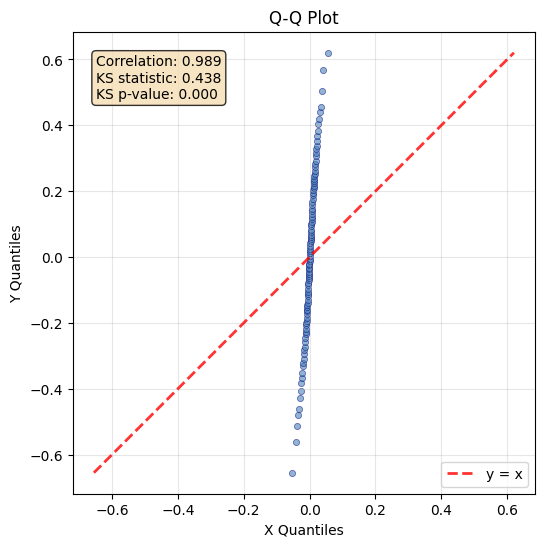

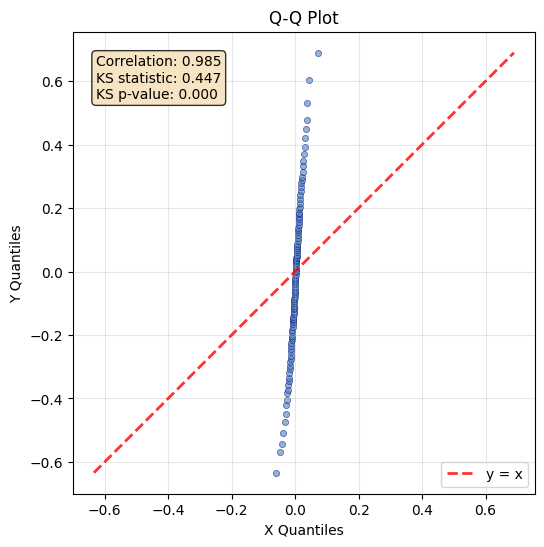

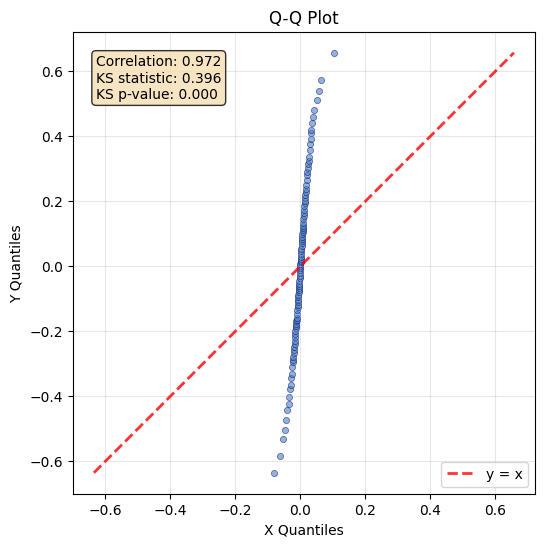

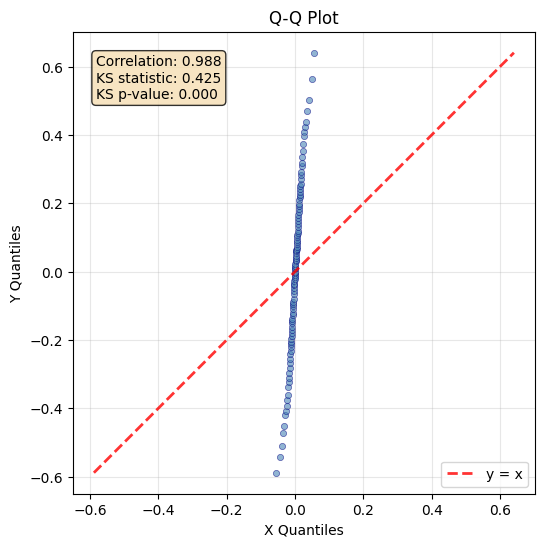

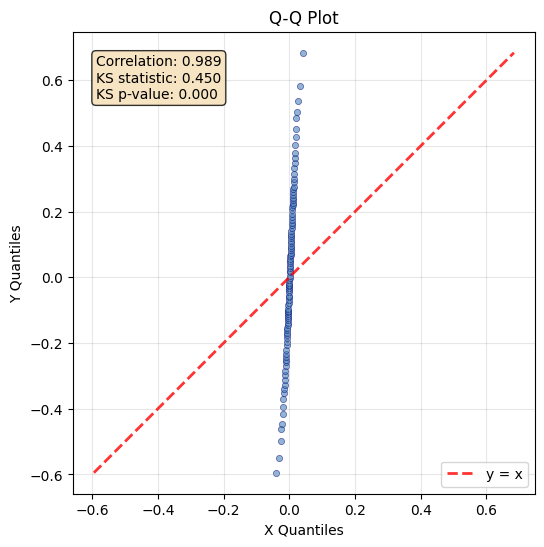

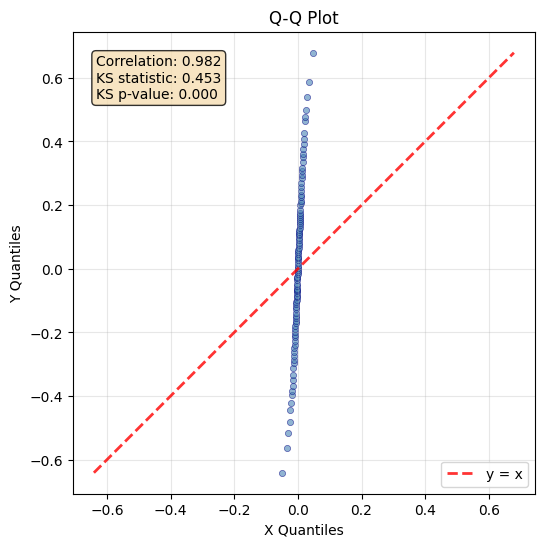

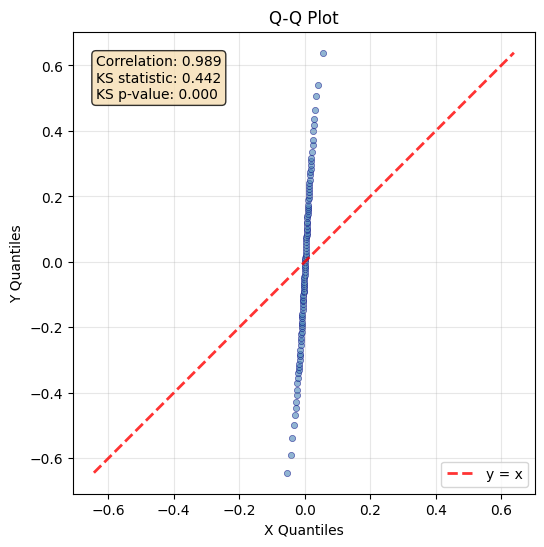

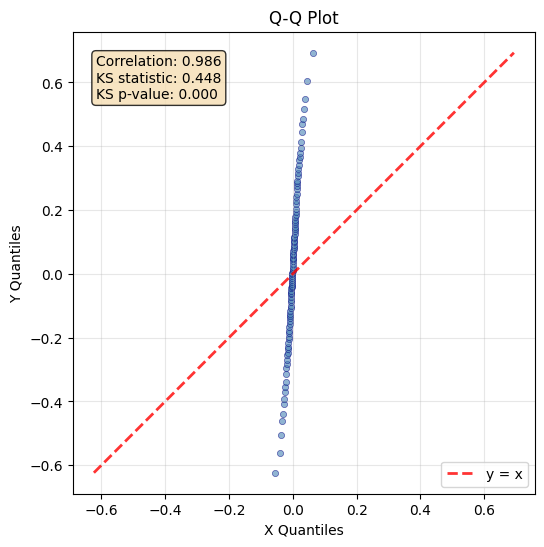

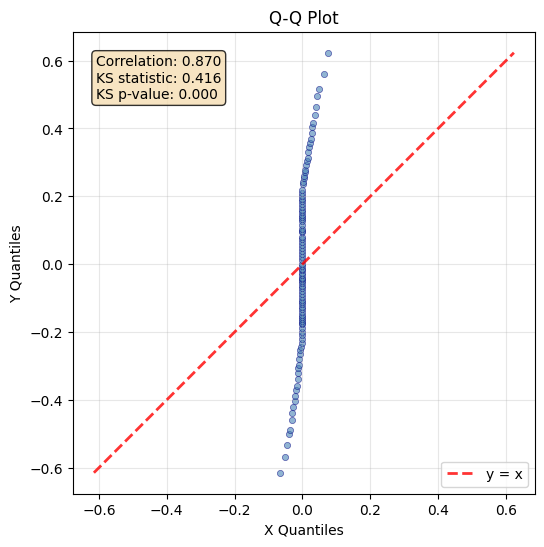

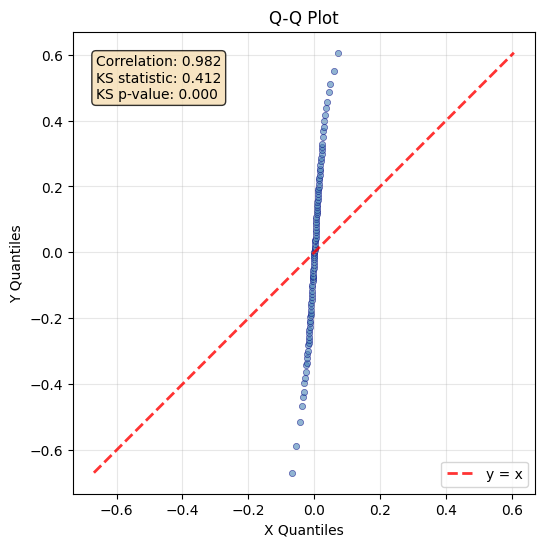

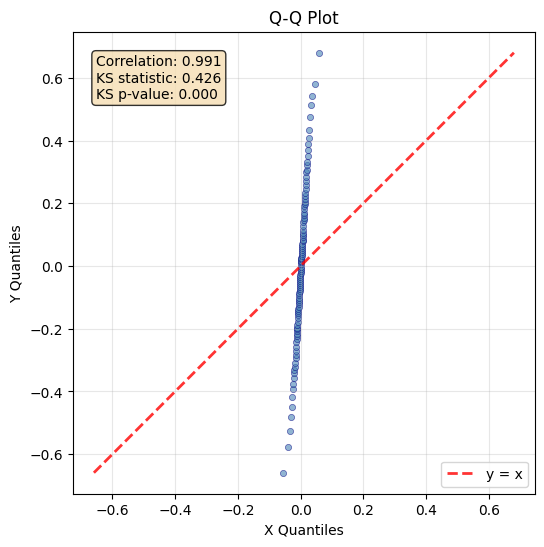

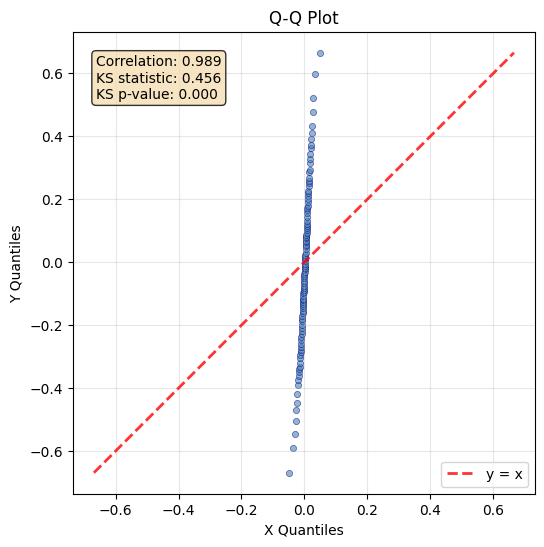

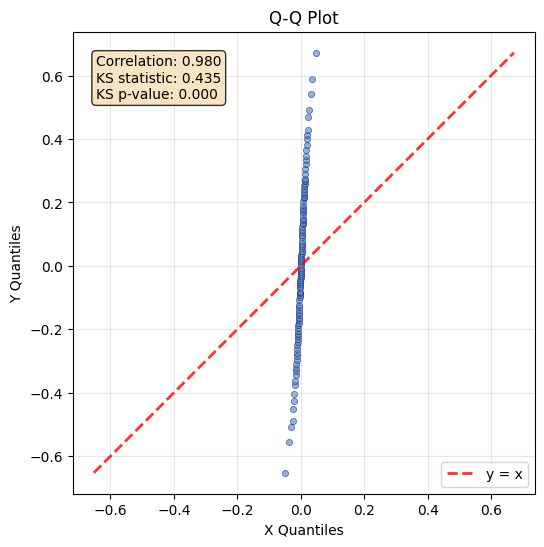

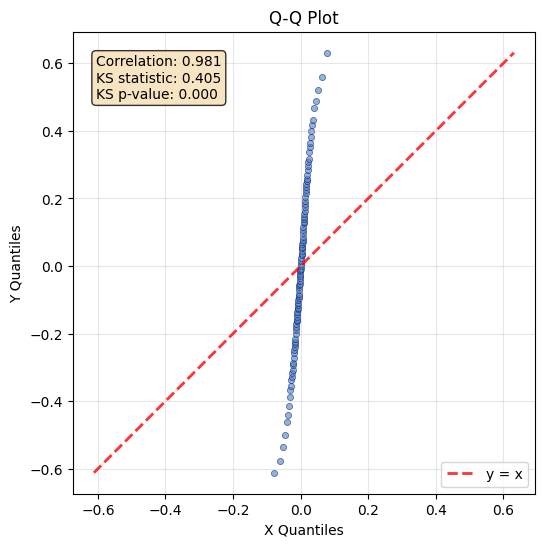

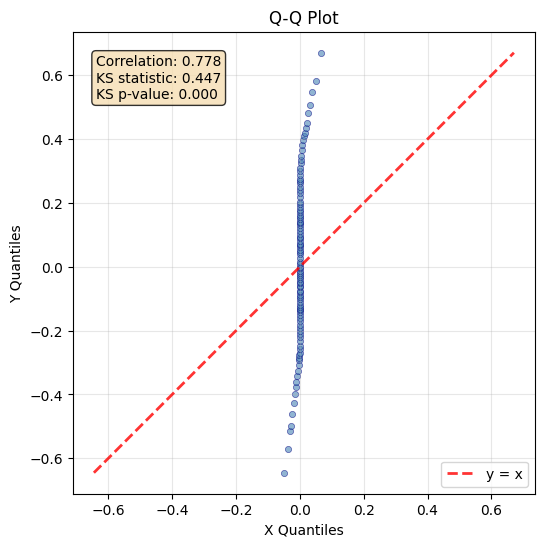

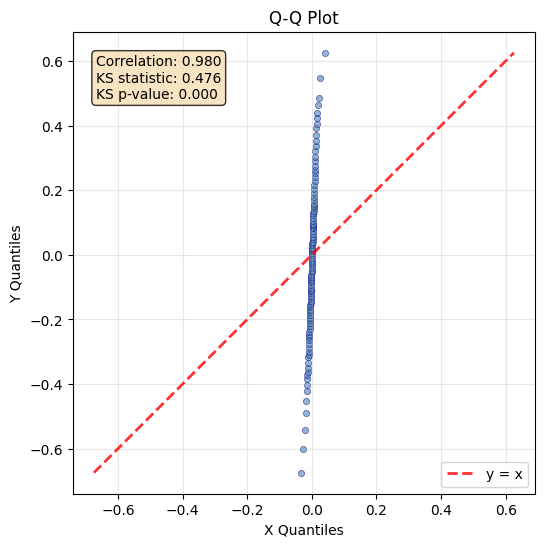

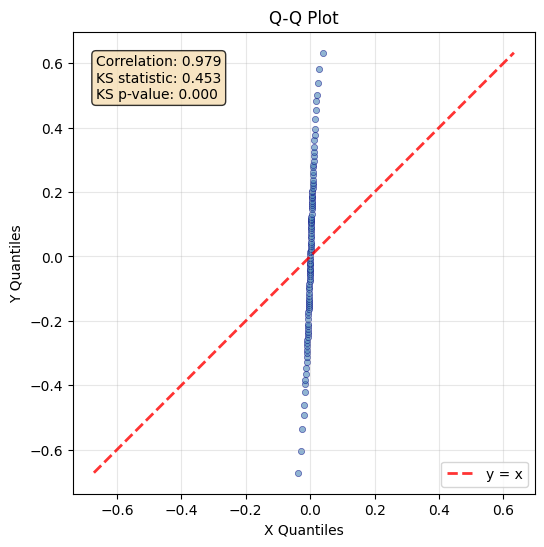

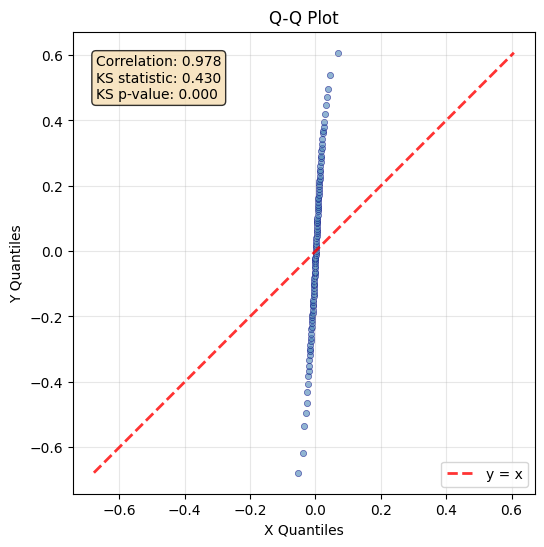

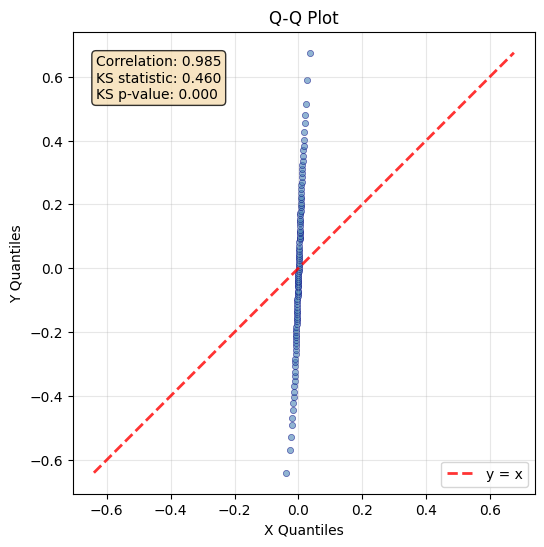

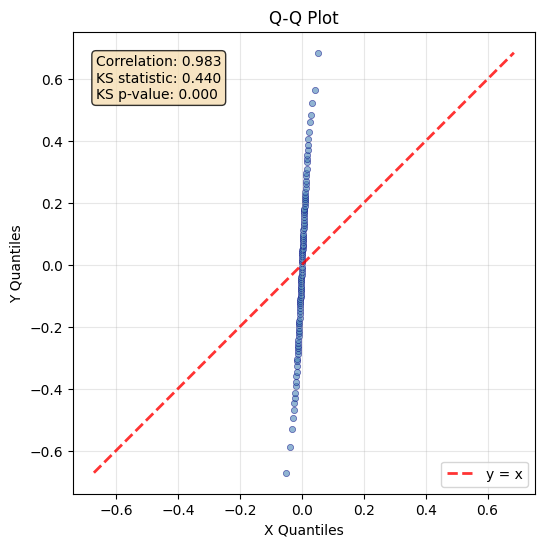

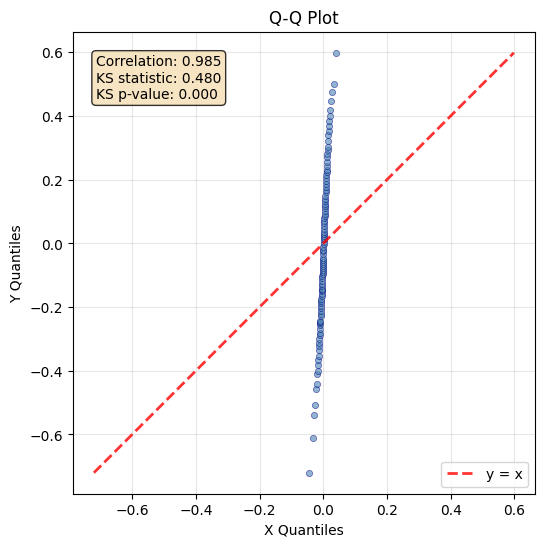

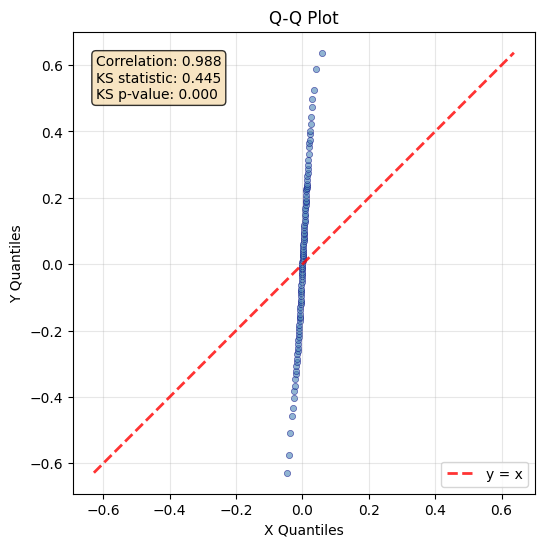

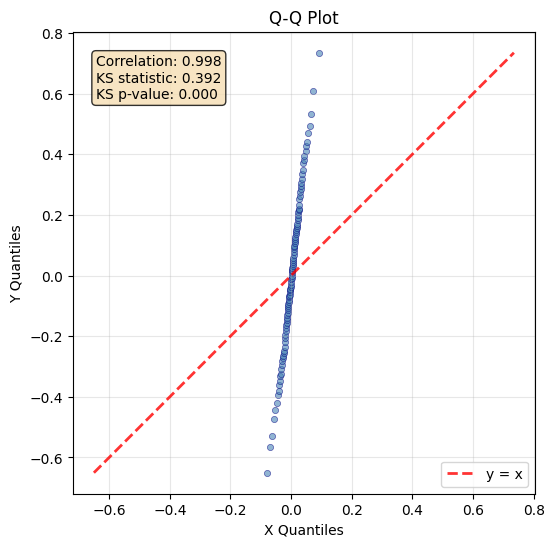

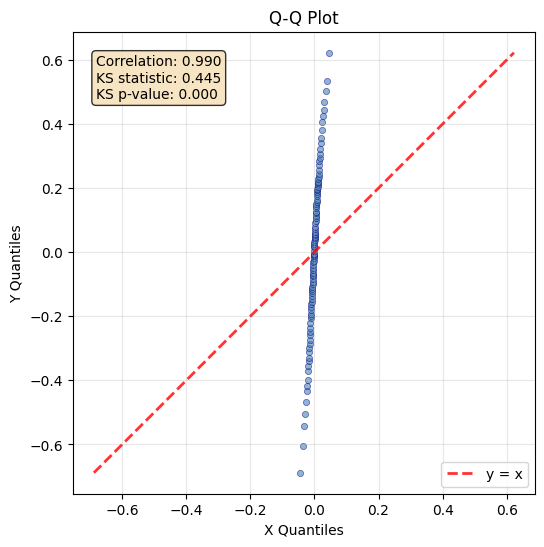

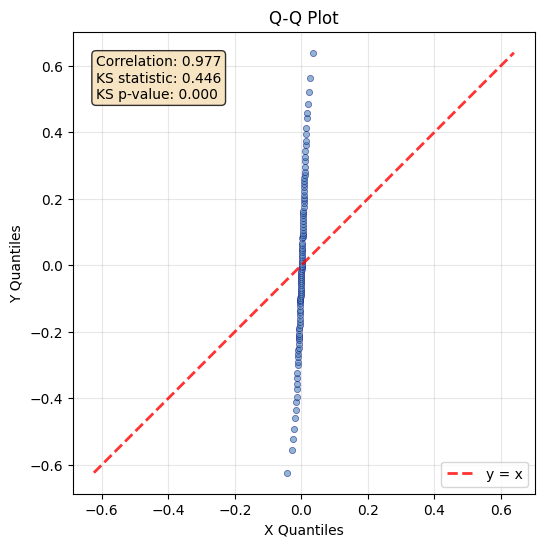

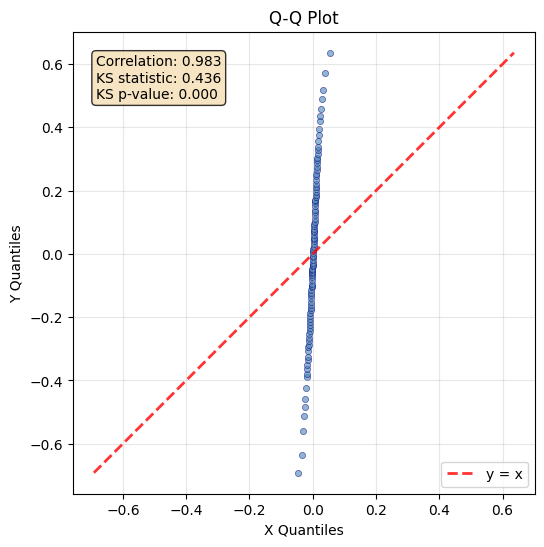

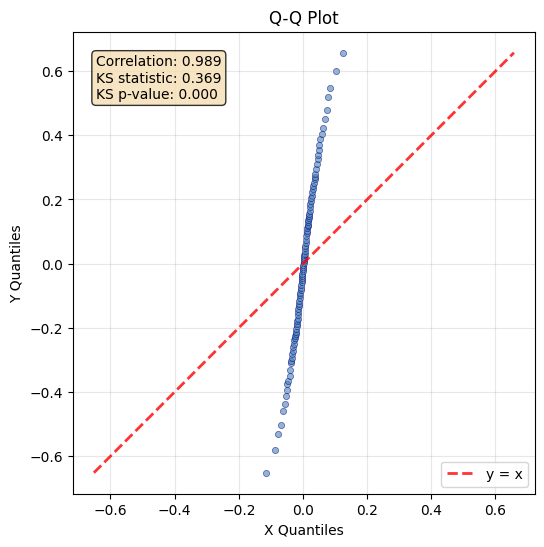

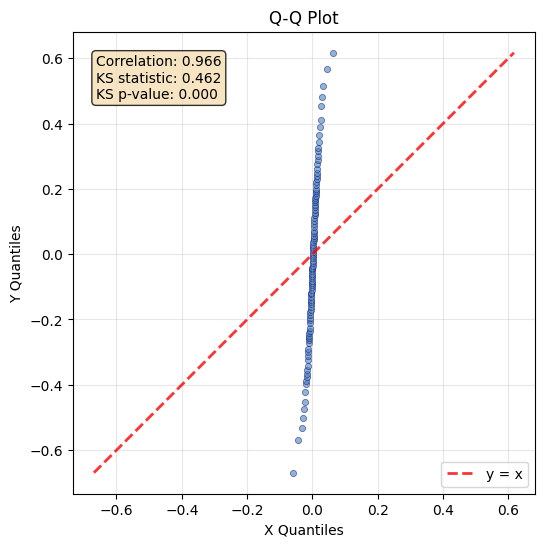

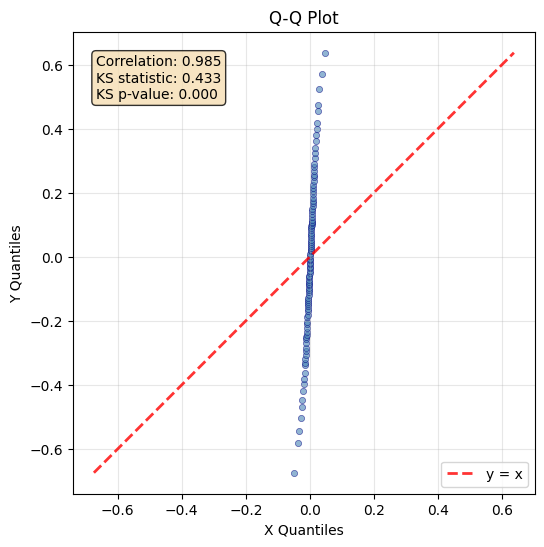

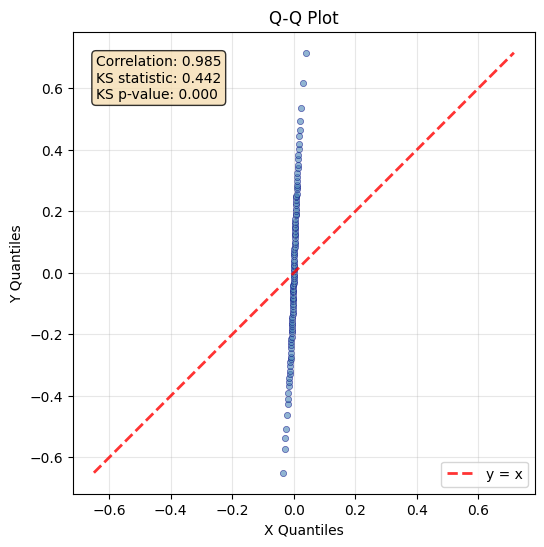

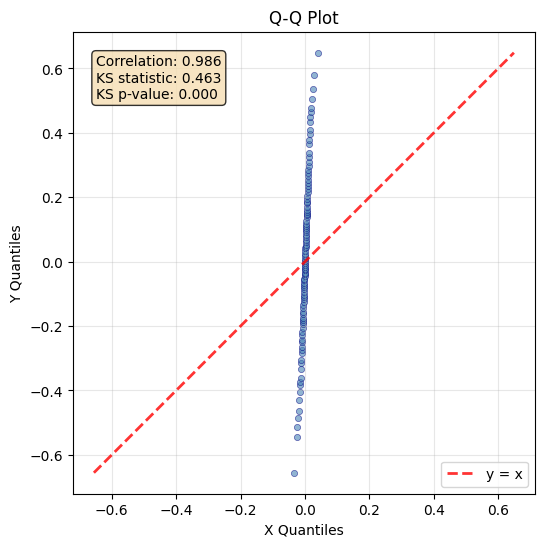

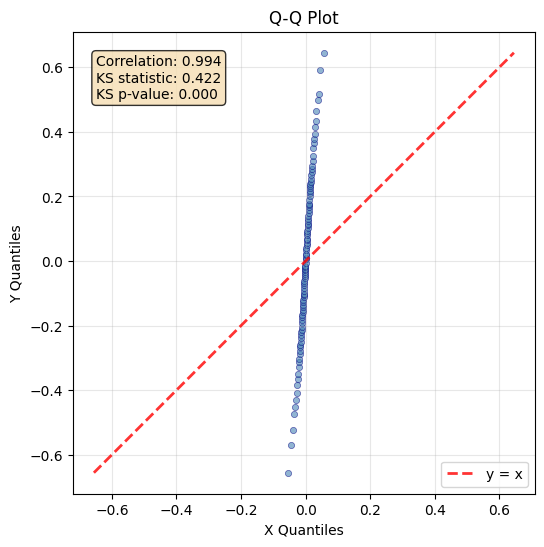

In [45]:
for i in range(0,32):
    _=qqplot(x=data_np[:,i], y= synthetic_data_np[:,i])
    plt.show()
    plt.close()